In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import pandas_datareader.fred as fred
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter

import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import chain

import datetime as dt

In [3]:
from src.utils import plot_dfs

In [4]:
st_loui_fed = {
     'y': 'GDP',
     'pi_core': 'CORESTICKM159SFRBATL',
     'pi': 'MEDCPIM158SFRBCLE',
     'r': 'FEDFUNDS',
     'I': 'GPDI',
     'c_s': 'PCEPILFE',
     'c': 'PCE',
     'Ix': 'IMPGS',
     'Zx': 'EXPGS',
     'n': 'HOANBS',
     'w': 'CES0500000003',
     'defl': 'A191RI1Q225SBEA',
     'recs': 'JHGDPBRINDX',
     'population': 'CNP16OV'
}

In [5]:
start = '1970-01-01'
end = '2022-12-01'
data = pd.DataFrame(index=pd.DatetimeIndex(pd.date_range(start, end, freq='QS')))
for key, val in st_loui_fed.items():
    data = data.join(fred.FredReader(symbols=val, start=start, end=end).read().rename(columns={val: key})) #, right_index=True, left_index=True)

recessions = (data['recs'] > data['recs'].quantile(.75)).copy()
df = data.copy()
df.drop(['recs', 'defl'], axis=1, inplace=True)

In [6]:
df.head()

,y,pi_core,pi,r,I,c_s,c,Ix,Zx,n,w,population
1970-01-01,1051.200,6.628279,NaN,8.98,168.113,21.608,628.7,53.517,57.031,62.116,NaN,135713
1970-04-01,1067.375,6.855423,NaN,8.10,171.455,21.857,636.0,55.204,60.411,61.309,NaN,136416
1970-07-01,1086.059,7.047140,NaN,7.21,173.904,22.098,648.5,56.431,60.519,61.008,NaN,137196
1970-10-01,1088.608,7.097175,NaN,6.20,166.754,22.376,658.3,57.888,60.873,60.546,NaN,137988
1971-01-01,1135.156,7.042661,NaN,4.14,189.495,22.694,676.1,58.651,63.221,60.826,NaN,138795


#### per capita variables
Popoulation dynmaics are not constantly recorded, instead quartlery data are mainly imputed mesurements. As a result population data series when updated by real measurements exhibit noisy dynmaics. Those are likley to distort data analysis and therefore best smoothed with the HP filter (lambda=10_000) Pfeifer (2021).

Do check out "A Guide to Specifying Observation Equations for the 
Estimation of DSGE Mode" (Pfeifer, 2021) for further advice on non-standard data preprocessing. https://drive.google.com/file/d/1r89OU5OE3CBa6tOlj6l3hNVWEaRH5Anv/viewls


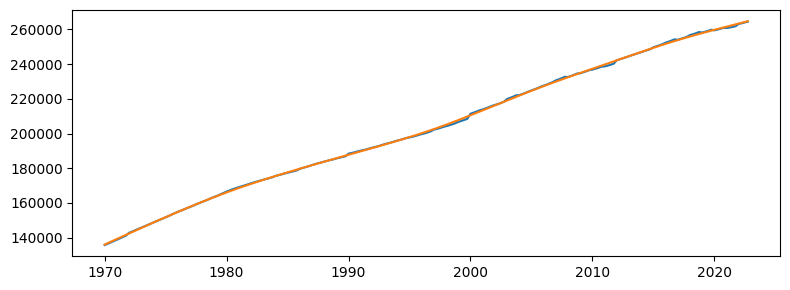

In [7]:
_, df['population_trend'] = hpfilter(df.population, lamb=10000)
df['population_trend'] = df.population_trend

fig = plt.figure(figsize=(8, 3))
plt.plot(df[['population']])
plt.plot(df[['population_trend']])
plt.tight_layout()

for col in ['y', 'I', 'c', 'Ix', 'Zx', 'n']:
    df[col] = df[col] / df['population_trend']

df.drop(['population', 'population_trend'], axis=1, inplace=True)

The St. Louis Fed lists percentage variables in anual percentage terms. When analysing quarterly data this needs to be transformed in to quarterly percentages.

In [8]:
for col in ['pi_core', 'r']:
    df[col] = (1 + df[col]/100) ** (1/4) - 1

#### steady state variables
In order to later form informative priors data pre-dating the analysis period is employed to estimate the distribution of steady state parameters following the defintion in Herbst & Schorfheide (2016). 

Herbst, E. P., & Schorfheide, F. (2016). Bayesian estimation of DSGE models. Princeton University Press.

In [9]:
mask = df.index > '1985-01-01'
df_priors = df[~mask].copy()
df = df[mask]
recessions = recessions[mask]

# average quarterly growth rate and std
df_priors['gamma'] = df_priors.y.diff().dropna()
γ = df_priors.gamma.mean()
γ_sig = df_priors.gamma.std()

# average inflation
π = df_priors.pi_core.mean()
π_sig = df_priors.pi_core.std()

# real interest rate
df_priors['r_int'] = df_priors.pi + df_priors.gamma + df_priors.r
r_int = df_priors.r_int.mean()
r_int_sig = df_priors.r_int.std()

# steady state values
df_priors['beta'] = (1 + 1 / (1 + df_priors['r_int'] / 400))
β = df_priors.beta.mean()
β_sig = df_priors.beta.std()

# transform into quarterly values
π = 1 + π / 400
π_sig = π_sig

γ = 1 + γ
γ_sig = γ_sig

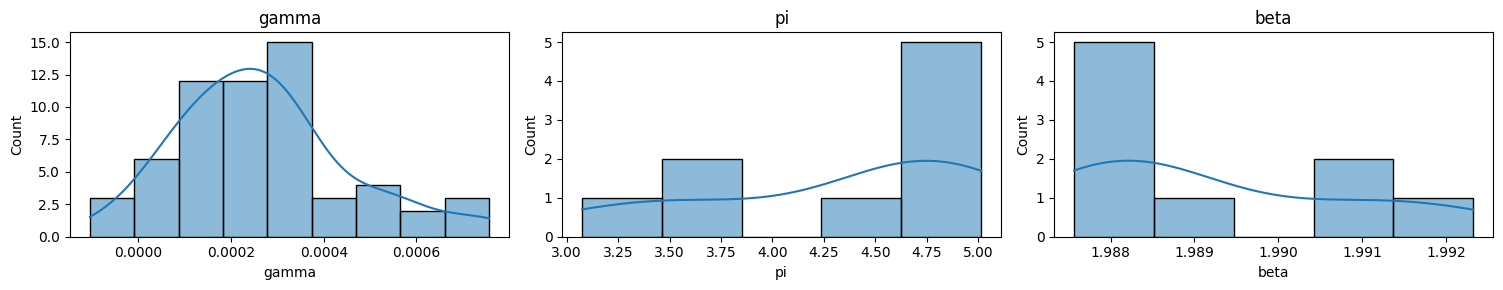

In [10]:
plot_dfs([df_priors[['gamma', 'pi', 'beta']]], sns.histplot, kde=True, figsize=(5, 3));

#### HP filter & log
We are log transforming because the final model will be log-linearized, as such it is describing log deviations in steady state. For the data to match these, logs need to be taken. This excludes all variables that are in percentages already, namely $\bf \pi$ and $r$.

The HP filter seperates long-term trend (steady-state) GDP from cycle fluctuations. It outputs decimal percentages, wherefore data that is in percentage terms already needs transformation into decimal percentages.

In [11]:
log_cols = ["y", "I", "c", "c_s", "Ix", "Zx", "n", "w"]
for col in log_cols:
    cyc, trend = hpfilter(np.log(df[col].dropna()), lamb=1600)
    df.loc[df[col].dropna().index, col] = cyc
    df.loc[df[col].dropna().index, f'{col}_trend'] = trend

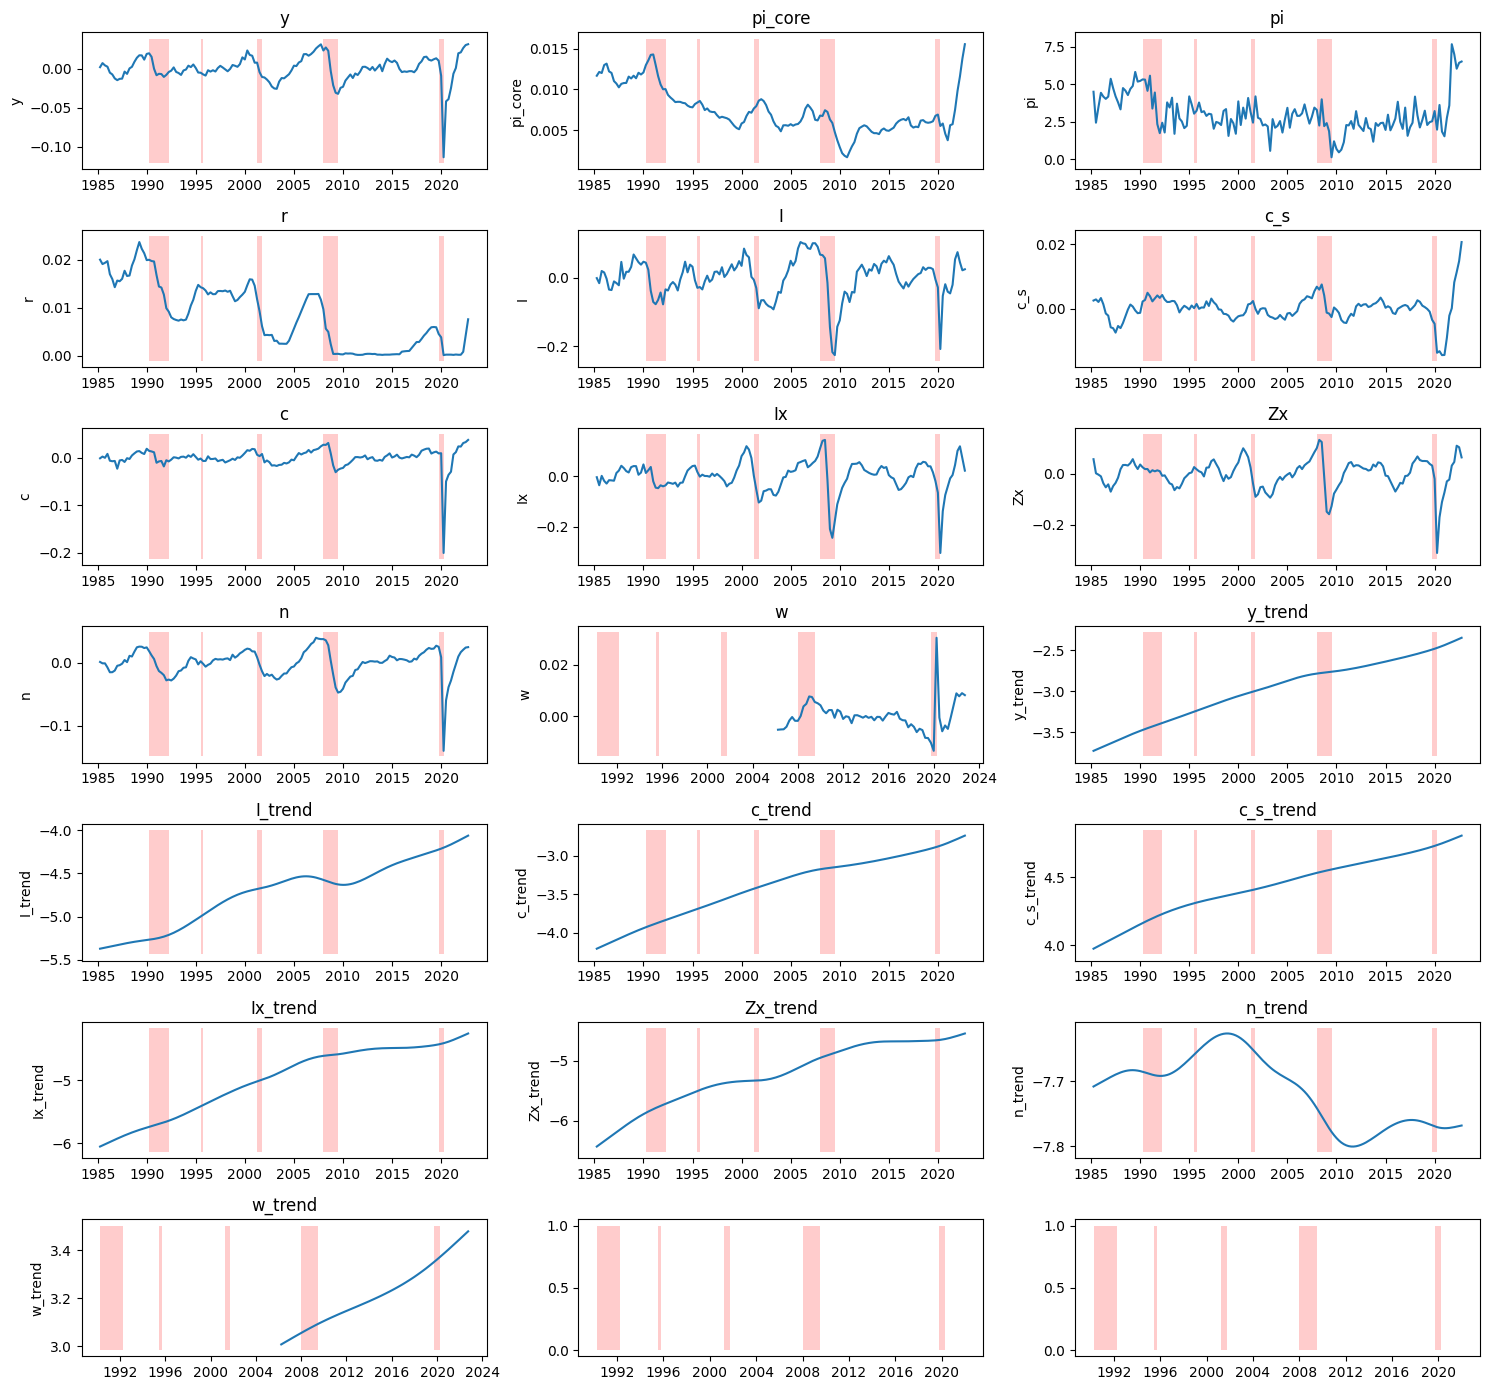

In [12]:
plot_dfs([df], sns.lineplot, when_crisis=recessions);

In [13]:
# drop trends
df = df[[item for item in df.columns if 'trend' not in item]]

covariance matrix

In [14]:
cov = np.cov(df.dropna().values.transpose())
cov = pd.DataFrame(cov, index=df.columns, columns=df.columns)
cov

,y,pi_core,pi,r,I,c_s,c,Ix,Zx,n,w
y,0.000489,0.000023,0.014465,0.000046,0.001301,0.000094,0.000621,0.001512,0.001481,0.000604,-0.000061
pi_core,0.000023,0.000005,0.002493,0.000004,0.000056,0.000009,0.000026,0.000048,0.000053,0.000029,0.000002
pi,0.014465,0.002493,1.992422,0.001149,0.041616,0.004104,0.016867,0.044766,0.039382,0.016088,0.001187
r,0.000046,0.000004,0.001149,0.000016,0.000152,0.000009,0.000044,0.000125,0.000124,0.000066,-0.000008
I,0.001301,0.000056,0.041616,0.000152,0.005166,0.000199,0.001420,0.004896,0.004126,0.001690,-0.000198
c_s,0.000094,0.000009,0.004104,0.000009,0.000199,0.000032,0.000112,0.000262,0.000288,0.000107,0.000003
c,0.000621,0.000026,0.016867,0.000044,0.001420,0.000112,0.000907,0.001882,0.001873,0.000775,-0.000099
Ix,0.001512,0.000048,0.044766,0.000125,0.004896,0.000262,0.001882,0.006427,0.005672,0.001849,-0.000196
Zx,0.001481,0.000053,0.039382,0.000124,0.004126,0.000288,0.001873,0.005672,0.005498,0.001814,-0.000186
n,0.000604,0.000029,0.016088,0.000066,0.001690,0.000107,0.000775,0.001849,0.001814,0.000810,-0.000096


In [15]:
cov.to_csv('covariance_matrix.csv')
df.to_csv('data_quarterly.csv')